# Raster manipulation 1

## About the data

Data from the Copernicus Digital Elevation Model (DEM):
- based on satellite LIDAR measurements of the earths surface 
- tracking elevation 
- tiles are 1degree x 1degree 
- value in each pixel represents vertical units measured in meters


In [14]:
# import libraries 
import os # working with file paths 
import numpy as np

import xarray as xr
import rioxarray as rioxr

import matplotlib.pyplot as plt

## Exercise 

1. Use `os` to create file path to grand canyon file and import the raster into a variable names `gc`

2. Plot the raster, check the crs, and create a histogram with updated bins

In [22]:
# load DEM .tif file 

#create filepath
dem_fp = os.path.join(os.getcwd(), # call current working directory
                      'data', # look inside data folder
                      'grand_canyon_DEM.tif') # indentify file 

# open file
gc = rioxr.open_rasterio(dem_fp)

# this is wgs84 epsg
print('CRS:', gc.rio.crs)

CRS: EPSG:4326


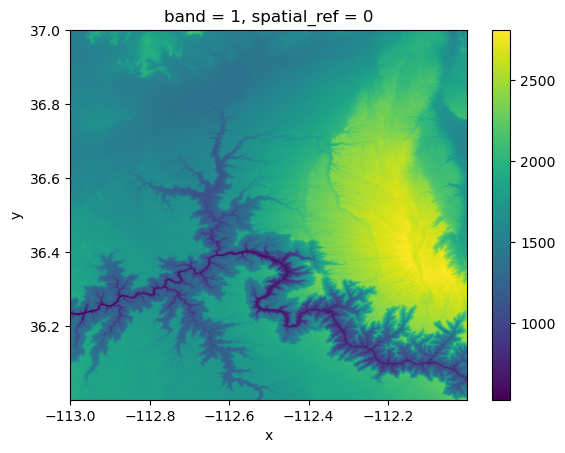

In [9]:
gc.plot()

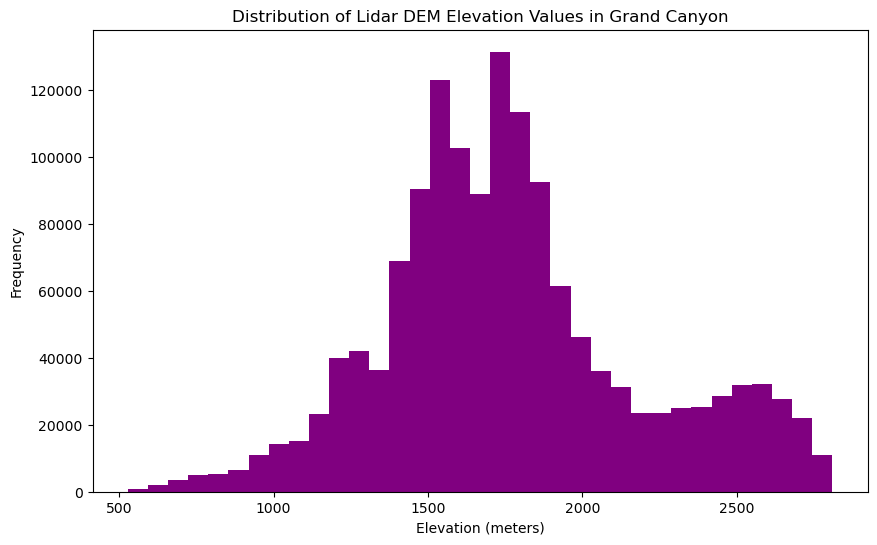

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

gc.plot.hist(ax = ax,
            bins = 35,
            color = "purple")

ax.set(title="Distribution of Lidar DEM Elevation Values in Grand Canyon",
       xlabel='Elevation (meters)',
       ylabel='Frequency')
plt.show()

## Dropping a dimension 

Notice our raster has an unnecessary extra dimenion: band.

This is making our dataset 3D, when its not eneded. 

We cna clean this `xarray.DataArray` by:

1. using the `squeeze()` method: if we dont pass any paramtersm then `squeeze()` gets rid of all dimensions of length 1

2. Getting rid of the coordinates associated to the dimensions we dropped. We can do this using the `drop()` method and specifying the nams of the coords we want to remove.

Lets do it:

In [23]:
# original dimensions
print(gc.dims, gc.coords, '\n')

gc = gc.squeeze()
print(gc.dims, gc.coords, '\n')
# coordinates are the ticks along the dimensions
# we still have the extra coordiantes even though we dropped the dimensions

gc = gc.drop('band')
print(gc.dims, "\n", gc.coords, "\n")

('band', 'y', 'x') Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -113.0 -113.0 -113.0 ... -112.0 -112.0 -112.0
  * y            (y) float64 37.0 37.0 37.0 37.0 37.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0 

('y', 'x') Coordinates:
    band         int64 1
  * x            (x) float64 -113.0 -113.0 -113.0 ... -112.0 -112.0 -112.0
  * y            (y) float64 37.0 37.0 37.0 37.0 37.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0 

('y', 'x') 
 Coordinates:
  * x            (x) float64 -113.0 -113.0 -113.0 ... -112.0 -112.0 -112.0
  * y            (y) float64 37.0 37.0 37.0 37.0 37.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0 



## Global information 

We can obtain global information applying usual `numpy` methods to our `xarray.DataArray`:

In [24]:
# get maximum elevation across all the array
gc.max()

<xarray.DataArray ()>
array(2808.80053711)
Coordinates:
    spatial_ref  int64 0

Notice that the output is another `xarray.DataArray`. 
This is inconvenient, when getting a single number.

To extract the value from a 1x1 `xarray.DataArray` as a number we use `.item()` method:

In [25]:
gc.max().item()

2808.800537109375

In [28]:
gc.max().values

array(2808.80053711)

## f-string

So far we have printed variables using *string concatenation* inside the `print()` function: we write commas between every string and variable we want to print. The `print()` function automatically concatinates the strings + variables.

For Example:

In [29]:
# minimum elevation
# print via concatination
print('Minimum elevation: ', gc.min().item())

Minimum elevation:  528.0


Another popular way of mixing strings and variables in print statements is by creating an **f-string** (formatted string). 

Simplest syntax:

```python
f"some text {replace}"
```

where `replace` can be variable, expression, or function or method call. 

Example:

In [31]:
# f-string with mean elevation 
f'Mean Elevation: {gc.min().item()}'

'Mean Elevation: 528.0'

Created a string replacing the value inside the curly brackets {}.
Notice the computation happens in real time as the string gets made : no need for extra variables.

**Advantages**
- more customization for the output without using extra function. 
- many customization opporunities!
- check format specification mini-language


Example:

In [34]:
print(f'Median elevation: {gc.median().item():.2f}') # .2f means rounding to 2 decimal places 

Median elevation: 1726.15


## Aggregation

Rasters with high spatial resolution can offer great detail for analysis. 
The downside, they can be challenging to process due to their size. 'Big files' depends on where you're working. 
It can be useful to use aggreggation method to spatially downsample and obtain a raster with coarser spatial resolution. 

To spatially downsample an `xarray.DataArray` we use the `coarsen()` method followed by an aggregator function. 
The general syntax for 2D `xarray.DataArray` is:

```python
xdata_array.coarsen(x = x_window, y = y_window).aggr()

```
where:
- xdata_array is 2D `xarray.DataArray` with dimensions x and y 
- `x` and `y` are names of the dimensions of the `xarray.DataArray` (could be 'lat'/'long')
- `x_window` and `y_window` are the dimensions of the window used to make the aggregation (x pixels by y pixels)
- `aggr()` is an aggregator funciton, used to calculate a single value for each window.

Example:

We want to coarsen our GC raster from 1200x1200 pixels to a raster of 60x60 pixels by calculating the max at each window. 
Remember, windows are non-overlapping.
Each window should be 20x20.
Aggregator function will be `max()`. 

In [41]:
# coarsen to 60x60 calculating the max in each window
gc_coarse = gc.coarsen(x = 20, 
                      y = 20).max() # aggregator function applied

old resolution: 1200x1200
ew resolution: 60x60


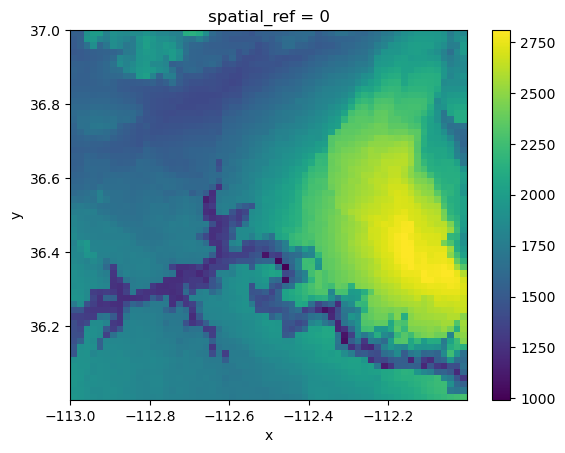

In [44]:
print(f'old resolution: {gc.rio.width}x{gc.rio.height}')
print(f'ew resolution: {gc_coarse.rio.width}x{gc_coarse.rio.height}')

gc_coarse.plot()

## Exercise 

1. Downsample the mean elevtion raster into a 240x240 raster.

2. Use f-strings to check if the bounds have changed

In [45]:
# coarsen to 60x60 calculating the max in each window
gc_mean = gc.coarsen(x = 5, 
                      y = 5).mean() # aggregator function applied

old resolution: (-113.00041666666667, 36.000416666666666, -112.00041666666667, 37.000416666666666)x(-113.00041666666667, 36.000416666666666, -112.00041666666667, 37.000416666666666)
ew resolution: (-112.99875, 36.00208333333333, -112.00208333333335, 36.99875)x(-112.99875, 36.00208333333333, -112.00208333333335, 36.99875)


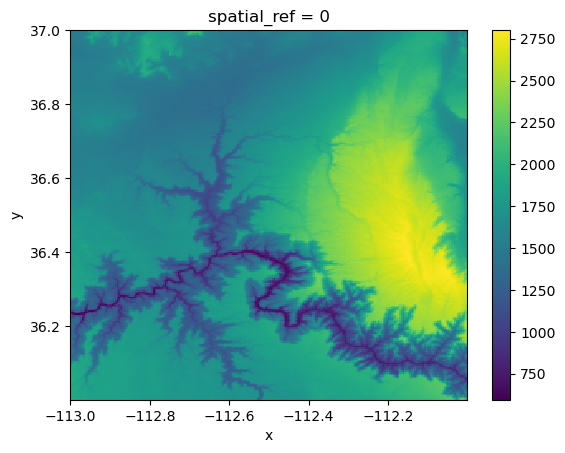

In [50]:
print(f'old resolution: {gc.rio.bounds()}x{gc.rio.bounds()}')
print(f'ew resolution: {gc_mean.rio.bounds()}x{gc_mean.rio.bounds()}')

gc_mean.plot()